# Assignement 1 Deivatives FINA60206A.A2023
by Prateek Sinha, Jeremie Couillard, Samuel Morin

In [34]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Question 1

## Functions

In [29]:
# Function to calculate the BSM adjustement for the binomial trees
def bsm_put_q1(S, K, r, y, dt, sigma):
    d1 = (np.log(S/K) + ((r - y) + (0.5 * sigma**2)) * dt) / (sigma * np.sqrt(dt))
    d2 = d1 - sigma * np.sqrt(dt)
    return K * np.exp(-r*dt) * stats.norm.cdf(-d2) - S * np.exp(-y*dt) * stats.norm.cdf(-d1)

In [168]:
# Function to extract one step of the binomial tree

def CRR_stock_tree(T, S0, r, y, sigma, N, step):
    # T = time to maturity
    # S0 = initial stock price
    # r = risk-free interest rate
    # y = dividend yield
    # sigma = stock price volatility
    # N = number of time steps in the model
    # step = specific time step for which to calculate the stock prices

    # precompute values
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp((r-y)*dt) - d)/(u - d)
    disc = np.exp(-(r)*dt)

    # initialise stock prices at maturity
    S = S0 * u**(np.arange(step,-1,-1)) * d**(np.arange(0,step+1,1))
    
    return(S) # returns stock prices at the specified step

In [169]:
# Returns put option prices at a step in a CRR tree with BSM adjustments at the penultimate step.

def CRR_option_tree(K, T, S0, r, y, sigma, N, step):
    # K = Strike price of the option
    # T = time to maturity
    # S0 = initial stock price
    # r = risk-free interest rate
    # y = dividend yield
    # sigma = stock price volatility
    # N = number of time steps in the model
    # step = specific time step for which to calculate the option prices
    
    # precompute values
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    q = (np.exp((r-y)*dt) - d)/(u - d)
    disc = np.exp(-(r)*dt)

    # initialise stock prices at maturity
    S = S0 * u**(np.arange(N,-1,-1)) * d**(np.arange(0,N+1,1))

    # option payoff
    C = np.maximum(0, K - S)
    
    if step < N:
        temp_N = N-1
        # Possible stock prices at 999th step
        S = S0 * u**(np.arange(temp_N,-1,-1)) * d**(np.arange(0,temp_N+1,1))

        # BSM adjustment at the 999th step
        C = np.array([bsm_put_q1(s,K,r,y,dt,sigma)for s in S])

        # Calculate option payoff at 999th step
        C = np.maximum(C, K - S)

        if step < N-1:
            # backward induction
            for i in np.arange(N-2,step-1,-1):
                S = S0 * u**(np.arange(i,-1,-1)) * d**(np.arange(0,i+1,1))
                C[:i+1] = disc * (q*C[0:i+1] + (1-q)*C[1:i+2])
                C = C[:-1]
                C = np.maximum(C, K-S)
            
    return C # return option prices at the specified step

In [170]:
# Returns put option price at a step in a CRR tree with BSM adjustments at the penultimate step.

def CRR_american_tree_BSM_adjustment(K, T, S0, r, y, sigma, N):
    # K = Strike price of the option
    # T = time to maturity
    # S0 = initial stock price
    # r = risk-free interest rate
    # y = dividend yield
    # sigma = stock price volatility
    # N = number of time steps in the model

    # Calculate time step size
    dt = T/N
    # Compute upward price movement factor
    u = np.exp(sigma*np.sqrt(dt))
    # Compute downward price movement factor
    d = 1/u
    # Calculate risk-neutral probability for upward move
    q = (np.exp((r-y)*dt) - d)/(u - d)
    # Calculate discount factor for one time step
    disc = np.exp(-(r)*dt)

    # Initialize possible stock prices at option's maturity
    S = S0 * u**(np.arange(N,-1,-1)) * d**(np.arange(0,N+1,1))

    # Calculate option payoff at maturity
    C = np.maximum(0, K - S)

    # Possible stock prices at 999th step
    S = S0 * u**(np.arange(N-1,-1,-1)) * d**(np.arange(0,N,1))

    # BSM adjustment at the 999th step
    C = np.array([bsm_put_q1(s,K,r,y,dt,sigma)for s in S])

    # Calculate option payoff at 999th step
    C = np.maximum(C, K - S)

    # Begin backward induction through the tree
    for i in np.arange(N-2,-1,-1):
        # Compute stock prices for the current time step
        S = S0 * u**(np.arange(i,-1,-1)) * d**(np.arange(0,i+1,1))
        # Compute option values based on possible future values
        C[:i+1] = disc * (q*C[0:i+1] + (1-q)*C[1:i+2])
        # Reduce size of option values array for next iteration
        C = C[:-1]
        # Check for early exercise opportunity for American option
        C = np.maximum(C, K-S)
    # Return the option's value at the initial time
    return C[0]

## Option Prices

### Initalise Parameters

In [171]:
# Initialise parameters for option pricing

S0 = 100      # Initial stock price
sigma = 0.3   # Stock price volatility (standard deviation of stock returns)
r = 0.04      # Risk-free interest rate
y = 0.02      # Dividend yield
N = 1000      # Number of time steps in the model
T = 3/12      # Time to maturity in years (3 months in this case)
dt = T/N      # Duration of each time step
K = [90, 100, 110]  # List of strike prices for the options

### Binomial Tree Prices for the American Put options for each K

In [174]:
binomial_price = []  # Store calculated binomial option prices

# Loop through strike prices to compute option prices
for i in range(len(K)):
    price_val = CRR_american_tree_BSM_adjustment(K[i], T, S0, r, y, sigma, N)
    binomial_price.append(price_val)

# Display option prices for each strike
print(f"Binomial tree prices: \nK=90: {binomial_price[0]} \nK=100: {binomial_price[1]} \nK=110: {binomial_price[2]}")

Binomial tree prices: 
K=90: 1.9054509896847356 
K=100: 5.7298538803062495 
K=110: 12.143342664653876


## Option Greeks

### Extracting stock and option binomial sub-trees

In [176]:
# Number of steps (upto step 2)
n = 3

# Compute and store stock prices for each step
stock_binomial_tree = []
for i in range(n):
    temp_step = CRR_stock_tree(T, S0, r, y, sigma, N, i)
    stock_binomial_tree.append(list(temp_step))
print(f"Stock tree: {stock_binomial_tree}")

# Compute and store option prices for K=90 for each step
option_binomial_tree_90 = []
for i in range(n):
    temp_step = CRR_option_tree(K[0], T, S0, r, y, sigma, N, i)
    option_binomial_tree_90.append(list(temp_step))

# Compute and store option prices for K=100 for each step
option_binomial_tree_100 = []
for i in range(n):
    temp_step = CRR_option_tree(K[1], T, S0, r, y, sigma, N, i)
    option_binomial_tree_100.append(list(temp_step))

# Compute and store option prices for K=110 for each step
option_binomial_tree_110 = []
for i in range(n):
    temp_step = CRR_option_tree(K[2], T, S0, r, y, sigma, N, i)
    option_binomial_tree_110.append(list(temp_step))

# Display computed option prices
print(f"\nOption tree K=90: {option_binomial_tree_90}")
print(f"\nOption tree K=100: {option_binomial_tree_100}")
print(f"\nOption tree K=110: {option_binomial_tree_110}")


Stock tree: [[100.0], [100.47546842991781, 99.52678157430094], [100.95319756211411, 100.0, 99.05580250538608]]

Option tree K=90: [[1.9054509896847356], [1.8061819300732265, 2.004496856268518], [1.710777942473999, 1.9013709137983523, 2.107391433651189]]

Option tree K=100: [[5.7298538803062495], [5.511831116214299, 5.947417308210212], [5.298811110652247, 5.724400596896359, 6.1699658860426245]]

Option tree K=110: [[12.143342664653876], [11.806987283076028, 12.479055388920306], [11.47442836369134, 12.13890681822794, 12.818558025000272]]


### Delta

In [177]:
def compute_binomial_delta(stock_tree, option_tree):
    # Calculate delta for the first node
    delta_node1 = (option_tree[1][0] - option_tree[1][1]) / (stock_tree[1][0] - stock_tree[1][1])
    
    # Calculate delta for the second node
    delta_node2 = (option_tree[2][0] - option_tree[2][1]) / (stock_tree[2][0] - stock_tree[2][1])
    
    # Calculate delta for the third node
    delta_node3 = (option_tree[2][1] - option_tree[2][2]) / (stock_tree[2][1] - stock_tree[2][2])
    
    delta = []
    # Append the calculated deltas to the delta list
    delta.append([delta_node1])
    delta.append([delta_node2, delta_node3])

    return delta

# Compute deltas for each strike price
delta_binomial_90 = compute_binomial_delta(stock_binomial_tree, option_binomial_tree_90)
delta_binomial_100 = compute_binomial_delta(stock_binomial_tree, option_binomial_tree_100)
delta_binomial_110 = compute_binomial_delta(stock_binomial_tree, option_binomial_tree_110)

# Display the computed delta values for each strike price
print(f"Delta K=90: {delta_binomial_90[0][0]}")
print(f"Delta K=100: {delta_binomial_100[0][0]}")
print(f"Delta K=110: {delta_binomial_110[0][0]}")

# Display the complete delta tree for each strike price
print(f"\nDelta tree K=90: {delta_binomial_90}")
print(f"Delta tree K=100: {delta_binomial_100}")
print(f"Delta tree K=110: {delta_binomial_110}")


Delta K=90: -0.2090415030219218
Delta K=100: -0.4591464395410839
Delta K=110: -0.7084193291655504

Delta tree K=90: [[-0.2090415030219218], [-0.19995117371223015, -0.21819642715434084]]
Delta tree K=100: [[-0.4591464395410839], [-0.44648612539481325, -0.47189840228124874]]
Delta tree K=110: [[-0.7084193291655504], [-0.6971046516976412, -0.7198189051012492]]


### Gamma

In [178]:
def compute_binomial_gamma(stock_tree, delta_tree):
    # Calculate gamma using delta values and stock prices from the tree
    gamma = (delta_tree[1][0] - delta_tree[1][1]) / (stock_tree[1][0] - stock_tree[1][1])
    
    return gamma

# Compute gammas for each strike price
gamma_binomial_90 = compute_binomial_gamma(stock_binomial_tree, delta_binomial_90)
gamma_binomial_100 = compute_binomial_gamma(stock_binomial_tree, delta_binomial_100)
gamma_binomial_110 = compute_binomial_gamma(stock_binomial_tree, delta_binomial_110)

# Display the computed gamma values for each strike price
print(f"Gamma K=90: {gamma_binomial_90}")
print(f"Gamma K=100: {gamma_binomial_100}")
print(f"Gamma K=110: {gamma_binomial_110}")

Gamma K=90: 0.019232113667525183
Gamma K=100: 0.02678679138008244
Gamma K=110: 0.023942835582810282


### Theta

In [179]:
def compute_binomial_theta(K, S, T, N, r, y, sigma, dt):
    # Calculate theta using option price difference over a small time interval (dt)
    theta = (CRR_american_tree_BSM_adjustment(K, T-dt, S, r, y, sigma, N) - CRR_american_tree_BSM_adjustment(K, T, S, r, y, sigma, N)) / dt
    return theta

# Compute theta for each strike price
theta_binomial_90 = compute_binomial_theta(K[0], S0, T, N, r, y, sigma, dt)
theta_binomial_100 = compute_binomial_theta(K[1], S0, T, N, r, y, sigma, dt)
theta_binomial_110 = compute_binomial_theta(K[2], S0, T, N, r, y, sigma, dt)

# Display the computed theta values for each strike price
print(f"Theta K=90: {theta_binomial_90}")
print(f"Theta K=100: {theta_binomial_100}")
print(f"Theta K=110: {theta_binomial_110}")

Theta K=90: -8.161141288732132
Theta K=100: -10.905978730907151
Theta K=110: -8.872560774435101


## Numerical PDE

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$

Where:
- \( V \): Option price
- \( t \): Time
- $\sigma$: Volatility of the underlying asset
- \( S \): Price of the underlying asset
- \( r \): Risk-free rate

### PDE with Greek Representations:
$$
\Theta + \frac{1}{2} \sigma^2 S^2 \Gamma + rS \Delta - rV = 0
$$

Where:
- $\Theta$: Time decay of the option
- $\Gamma$: Measures the rate of change in the option's delta in response to a change in the underlying asset price
- $\Delta$: Rate of change of the option price with respect to a change in the underlying asset price


- $( \Theta + \frac{1}{2} \sigma^2 S^2 \Gamma + rS\Delta)$ is the **Value Side**.
- $( rV )$ is the **Cost Side**.

If these values are close, the PDE holds numerically with our binomial calculations.


In [202]:
# Compute the LHS of the PDE for puts using option Greeks and parameters
PDE_binomial_cost_90 = ((theta_binomial_90) + (0.5 * sigma**2 * S0**2 * gamma_binomial_90) + ((r-y) * S0 * delta_binomial_90[0][0]))
PDE_binomial_cost_100 = ((theta_binomial_100) + (0.5 * sigma**2 * S0**2 * gamma_binomial_100) + ((r-y) * S0 * delta_binomial_100[0][0]))
PDE_binomial_cost_110 = ((theta_binomial_110) + (0.5 * sigma**2 * S0**2 * gamma_binomial_110) + ((r-y) * S0 * delta_binomial_110[0][0]))

#Compute the RHS of the PDE for the puts 
PDE_binomial_value_90 = r*binomial_price[0]
PDE_binomial_value_100 = r*binomial_price[1]
PDE_binomial_value_110 = r*binomial_price[2]

print(f"PDE Value Side K=90: {PDE_binomial_value_90}")
print(f"PDE Value Side K=100: {PDE_binomial_value_100}")
print(f"PDE Value Side K=110: {PDE_binomial_value_110}")

print(f"\nPDE cost Side K=90: {PDE_binomial_value_90}")
print(f"PDE cost Side K=100: {PDE_binomial_value_100}")
print(f"PDE cost Side K=110: {PDE_binomial_value_110}")

print(f"\nDifference K=90: {PDE_binomial_cost_90 - PDE_binomial_value_90}")
print(f"Difference K=100: {PDE_binomial_cost_100 - PDE_binomial_value_100}")
print(f"Difference K=110: {PDE_binomial_cost_110 - PDE_binomial_value_110}")

PDE Value Side K=90: 0.07621803958738943
PDE Value Side K=100: 0.22919415521224998
PDE Value Side K=110: 0.48573370658615506

PDE cost Side K=90: 0.07621803958738943
PDE cost Side K=100: 0.22919415521224998
PDE cost Side K=110: 0.48573370658615506

Difference K=90: -0.0009911839770325725
Difference K=100: 0.000590355835528994
Difference K=110: -0.0008571270877297255


# Question 2

## Functions

In [112]:
# Function to calculate the BSM adjustement for the trinomial trees

def trinomial_stock_tree(S, T, N, r, y, sigma, step):
    dt = T/N
    u = np.exp(sigma*np.sqrt(3*dt))
    d = 1/u
    m = 1
    q_u = (np.sqrt((dt)/(12*(sigma)**2)))*(r - y - ((sigma**2)/2)) + (1/6)
    q_m = 2/3
    q_d = -((np.sqrt((dt)/(12*(sigma)**2)))*(r - y - ((sigma**2)/2))) + (1/6)
    disc = np.exp(-(r-y)*dt)

    # Vectorized computation for the number of up and down moves for each node
    up_moves = np.clip(step - np.arange(0, 2*step+1), 0, step)
    down_moves = np.clip(np.arange(0, 2*step+1) - step, 0, step)
    
    # Calculate stock prices for each node based on the number of up and down moves
    S = S0 * (u**up_moves) * (d**down_moves)
    
    return S

In [152]:
# Function to extract one step of the binomial tree

def trinomial_option_tree(K, S, T, N, r, y, sigma, step):
    dt = T/N
    u = np.exp(sigma*np.sqrt(3*dt))
    d = 1/u
    m = 1
    q_u = (np.sqrt((dt)/(12*((sigma)**2))))*(r - y - ((sigma**2)/2)) + (1/6)
    q_m = 2/3
    q_d = -(np.sqrt((dt)/(12*((sigma)**2)))*(r - y - ((sigma**2)/2))) + (1/6)
    disc = np.exp(-(r)*dt)

    
    # Vectorized computation for the number of up and down moves for each node at maturity
    up_moves = np.clip(N - np.arange(0, 2*N+1), 0, N)
    down_moves = np.clip(np.arange(0, 2*N+1) - N, 0, N)
    S = S0 * (u**up_moves) * (d**down_moves)
    
    # Option values at maturity
    C = np.maximum(K - S, 0)
    
    if step < N:
        temp_N = N-1
        up_moves = np.clip(temp_N - np.arange(0, 2*temp_N+1), 0, temp_N)
        down_moves = np.clip(np.arange(0, 2*temp_N+1) - temp_N, 0, temp_N)
        S = S0 * (u**up_moves) * (d**down_moves)
        C = np.array([bsm_put_q1(s,K,r,y,dt,sigma)for s in S])
        C = np.maximum(K - S, C)

        if step < N-1:
            # Backward induction
            for i in np.arange(N-2, step-1, -1):
                up_moves = np.clip(i - np.arange(0, 2*i+1), 0, i)
                down_moves = np.clip(np.arange(0, 2*i+1) - i, 0, i)
                S = S0 * (u**up_moves) * (d**down_moves)

                # Compute option values based on possible future values
                C[0:((2*i)+1)] = disc * (q_u*C[0:((2*i)+1)] + q_m*C[1:((2*i)+2)] + q_d*C[2:((2*i)+3)])
                # Reduce size of option values array for next iteration
                C = C[:-2]
                # Check for early exercise opportunity for American option
                C = np.maximum(C, K-S)
    
    return C

In [137]:
# # Function to extract price of the trinomial tree 

def trinomial_american_tree(K, S, T, N, r, y, sigma):
  dt = T/N
  u = np.exp(sigma*np.sqrt(3*dt))
  d = 1/u
  m = 1
  q_u = (np.sqrt((dt)/(12*(sigma)**2)))*(r - y - ((sigma**2)/2)) + (1/6)
  q_m = 2/3
  q_d = -((np.sqrt((dt)/(12*(sigma)**2)))*(r - y - ((sigma**2)/2))) + (1/6)
  disc = np.exp(-(r)*dt)

  # Vectorized computation for the number of up and down moves for each node at maturity
  up_moves = np.clip(N - np.arange(0, 2*N+1), 0, N)
  down_moves = np.clip(np.arange(0, 2*N+1) - N, 0, N)
  S = S0 * (u**up_moves) * (d**down_moves)
    
  # Option values at maturity
  C = np.maximum(K - S, 0)
    
  # Adjustment at the penultimate step
  temp_N = N-1
  up_moves = np.clip(temp_N - np.arange(0, 2*temp_N+1), 0, temp_N)
  down_moves = np.clip(np.arange(0, 2*temp_N+1) - temp_N, 0, temp_N)
  S = S0 * (u**up_moves) * (d**down_moves)
  C = np.array([bsm_put_q1(s,K,r,y,dt,sigma)for s in S])
  C = np.maximum(K - S, C)

  # Backward induction
  for i in np.arange(N-2, -1, -1):
    up_moves = np.clip(i - np.arange(0, 2*i+1), 0, i)
    down_moves = np.clip(np.arange(0, 2*i+1) - i, 0, i)
    S = S0 * (u**up_moves) * (d**down_moves)

    # Compute option values based on possible future values
    C[0:((2*i)+1)] = disc * (q_u*C[0:((2*i)+1)] + q_m*C[1:((2*i)+2)] + q_d*C[2:((2*i)+3)])
    # Reduce size of option values array for next iteration
    C = C[:-2]
    # Check for early exercise opportunity for American option
    C = np.maximum(C, K-S)

  return C[0]

## Option Prices

In [115]:
# Initialise parameters
S0 = 100
sigma = 0.3
r = 0.04
y = 0.02
N = 1000
T = 3/12
dt = T/N
K = [90, 100, 110]

In [186]:
trinomial_price =[]
for i in range(len(K)):
    price_val = trinomial_american_tree(K[i], S0, T, N, r, y, sigma)
    trinomial_price.append(price_val)
print(f"Trinomial tree price: \nK=90: {trinomial_price[0]}, \nK=100: {trinomial_price[1]}, \nK=110: {trinomial_price[2]}")

Trinomial tree price: 
K=90: 1.905147658846689, 
K=100: 5.729126293249289, 
K=110: 12.14275151045618


## Option Greeks

In [187]:
# Storing stock and option tree upto step 2
n = 3
stock_trinomial_tree = []
for i in range(n):
    temp_step = trinomial_stock_tree(S0, T, N, r, y, sigma, i)
    stock_trinomial_tree.append(list(temp_step))

print(f"Stock tree: {stock_trinomial_tree}")

option_trinomial_tree_90 = []
option_trinomial_tree_100 = []
option_trinomial_tree_110 = []

for i in range(n):
    temp_step = trinomial_option_tree(K[0], S0, T, N, r, y, sigma, i)
    option_trinomial_tree_90.append(list(temp_step))

for i in range(n):
    temp_step = trinomial_option_tree(K[1], S0, T, N, r, y, sigma, i)
    option_trinomial_tree_100.append(list(temp_step))

for i in range(n):
    temp_step = trinomial_option_tree(K[2], S0, T, N, r, y, sigma, i)
    option_trinomial_tree_110.append(list(temp_step))

print(f"\nOption tree K=90: {option_trinomial_tree_90}")
print(f"\nOption tree K=100: {option_trinomial_tree_100}")
print(f"\nOption tree K=110: {option_trinomial_tree_110}")

Stock tree: [[100.0], [100.82496809809152, 100.0, 99.18178193987733], [101.65674191981171, 100.82496809809152, 100.0, 99.18178193987733, 98.37025868769376]]

Option tree K=90: [[1.905147658846689], [1.7371446746455248, 1.903108093164942, 2.080639299562381], [1.5804651548700144, 1.7351768840746127, 1.9010679135607529, 2.078530613633208, 2.2679330170431227]]

Option tree K=100: [[5.729126293249289], [5.3566834078191725, 5.726400130552554, 6.111095875736262], [4.999322183372369, 5.3539435294085465, 5.7236724527613, 6.108389249673157, 6.507922672482568]]

Option tree K=110: [[12.14275151045618], [11.564231600264025, 12.140533970526192, 12.728213735468481], [10.997522136949916, 11.561910536772524, 12.13831568175135, 12.726102103466578, 13.324614669188486]]


### Delta

In [189]:
def compute_trinomial_delta(stock_tree, option_tree):
    delta_node1 = (option_tree[1][0] - option_tree[1][2])/ (stock_tree[1][0] - stock_tree[1][2])
    delta_node2 = (option_tree[2][0] - option_tree[2][2])/ (stock_tree[2][0] - stock_tree[2][2])
    delta_node3 = (option_tree[2][2] - option_tree[2][4])/ (stock_tree[2][2] - stock_tree[2][4])
    delta = []
    delta.append([delta_node1])
    delta.append([delta_node2,delta_node3])

    return delta

delta_trinomial_90 = compute_trinomial_delta(stock_trinomial_tree, option_trinomial_tree_90)
delta_trinomial_100 = compute_trinomial_delta(stock_trinomial_tree, option_trinomial_tree_100)
delta_trinomial_110 = compute_trinomial_delta(stock_trinomial_tree, option_trinomial_tree_110)

# Display the computed delta values for each strike price
print(f"Delta K=90: {delta_trinomial_90[0][0]}")
print(f"Delta K=100: {delta_trinomial_100[0][0]}")
print(f"Delta K=110: {delta_trinomial_110[0][0]}")

# Display the complete delta tree for each strike price
print(f"\nDelta tree K=90: {delta_trinomial_90}")
print(f"Delta tree K=100: {delta_trinomial_100}")
print(f"Delta tree K=110: {delta_trinomial_110}")

Delta K=90: -0.20904181988129972
Delta K=100: -0.4591156419775236
Delta K=110: -0.708368999693539

Delta tree K=90: [[-0.20904181988129972], [-0.19351400170231442, -0.22510634093408433]]
Delta tree K=100: [[-0.4591156419775236], [-0.4372137028266025, -0.48121147436060285]]
Delta tree K=110: [[-0.708368999693539], [-0.688576495324683, -0.7279063115596013]]


### Gamma

In [160]:
def compute_trinomial_gamma(stock_tree, delta_tree):
    gamma = (delta_tree[1][0] - delta_tree[1][1])/ ((stock_tree[1][0] - stock_tree[1][2]))

    return gamma

gamma_trinomial_90 = compute_trinomial_gamma(stock_trinomial_tree, delta_trinomial_90)
gamma_trinomial_100 = compute_trinomial_gamma(stock_trinomial_tree, delta_trinomial_100)
gamma_trinomial_110 = compute_trinomial_gamma(stock_trinomial_tree, delta_trinomial_110)

print(f"Gamma K=90: {gamma_trinomial_90}")
print(f"Gamma K=100: {gamma_trinomial_100}")
print(f"Gamma K=110: {gamma_trinomial_110}")

Gamma K=90: 0.019226269083293845
Gamma K=100: 0.026775889824812642
Gamma K=110: 0.023935094656384978


### Theta

In [139]:
def compute_trinomial_theta(K, S, T, N, r, y, sigma, dt):
    theta = (trinomial_american_tree(K, S, T-dt, N, r, y, sigma) - trinomial_american_tree(K, S, T, N-1, r, y, sigma)) / dt

    return theta

theta_trinomial_90 = compute_trinomial_theta(K[0], S0, T, N, r, y, sigma, dt)
theta_trinomial_100 = compute_trinomial_theta(K[1], S0, T, N, r, y, sigma, dt)
theta_trinomial_110 = compute_trinomial_theta(K[2], S0, T, N, r, y, sigma, dt)

print(f"Theta K=90: {theta_trinomial_90}")
print(f"Theta K=100: {theta_trinomial_100}")
print(f"Theta K=110: {theta_trinomial_110}")

Theta K=90: -8.157591223884708
Theta K=100: -10.903939275863195
Theta K=110: -8.86809342721051


## Numerical PDE

### PDE with Greek Representations:
$$
\Theta + \frac{1}{2} \sigma^2 S^2 \Gamma + rS \Delta - rV = 0
$$

Where:
- $\Theta$: Time decay of the option
- $\Gamma$: Measures the rate of change in the option's delta in response to a change in the underlying asset price
- $\Delta$: Rate of change of the option price with respect to a change in the underlying asset price


- $( \Theta + \frac{1}{2} \sigma^2 S^2 \Gamma + rS\Delta)$ is the **Value Side**.
- $( rV )$ is the **Cost Side**.

If these values are close, the PDE holds numerically with our binomial calculations.

In [190]:
PDE_trinomial_value_90 = ((theta_trinomial_90) + (0.5 * sigma**2 * S0**2 * gamma_trinomial_90) + ((r-y) * S0 * delta_trinomial_90[0][0]))
PDE_trinomial_value_100 = ((theta_trinomial_100) + (0.5 * sigma**2 * S0**2 * gamma_trinomial_100) + ((r-y) * S0 * delta_trinomial_100[0][0]))
PDE_trinomial_value_110 = ((theta_trinomial_110) + (0.5 * sigma**2 * S0**2 * gamma_trinomial_110) + ((r-y) * S0 * delta_trinomial_110[0][0]))
    
print(f"PDE Value Side K=90: {PDE_trinomial_value_90}")
print(f"PDE Value Side K=100: {PDE_trinomial_value_100}")
print(f"PDE Value Side K=110: {PDE_trinomial_value_110}")

print(f"\nPDE Value Side K=90: {PDE_trinomial_value_90}")
print(f"PDE Value Side K=100: {PDE_trinomial_value_100}")
print(f"PDE Value Side K=110: {PDE_trinomial_value_110}")

print(f"\nDifference K=90: {PDE_trinomial_value_90 - r*trinomial_price[0]}")
print(f"Difference K=100: {PDE_trinomial_value_100 - r*trinomial_price[1]}")
print(f"Difference K=110: {PDE_trinomial_value_110 - r*trinomial_price[2]}")

PDE Value Side K=90: 0.07614622383492187
PDE Value Side K=100: 0.22697986134744796
PDE Value Side K=110: 0.4859611687756522

PDE Value Side K=90: 0.07614622383492187
PDE Value Side K=100: 0.22697986134744796
PDE Value Side K=110: 0.4859611687756522

Difference K=90: -5.9682518945697316e-05
Difference K=100: -0.0021851903825235997
Difference K=110: 0.0002511083574050499


# Question 3

## Functions

In [195]:
# function to calculate tau
def tau_calc(t,T):
    return T-t

# function to calculate beta
def beta(sigma, r, m, t, T):
    return 3*sigma/4 - r/(2*sigma) + m/(2*np.sqrt(tau_calc(t,T)))

# function to calculate erf
def erf(x):
    return 2*stats.norm.cdf((x*np.sqrt(2)), loc=0, scale=1) - 1

# frontier function
def B(sigma, r, t, T, K):
    # solving for m
    m = fsolve(m_root, 0, args=(t,T,r,sigma))[0]
    return K * np.exp(-(r+(sigma**2)/2)*(T-t)-sigma*np.sqrt(T-t)*m)

# function d_2 from class notes p69
def d_2(x,t,k):
    # setting some variables
    r = 0.04
    sigma = 0.3
    return (np.log(x/k) + (r - (sigma**2)/2) * t) / (sigma * np.sqrt(t))

# defining equation to find the root of m
def m_root(m_var, *parameters):
    # setting variables
    m = m_var
    t, T, r, sigma = parameters

    # splitting both sides into the right and left side seen in the class notes to make it readable
    left_side = sigma * np.exp(-(r + (sigma ** 2) / 2) * tau_calc(t, T) - sigma * np.sqrt(tau_calc(t, T)) * m)*stats.norm.cdf(-m)
    right_side = r * erf(np.sqrt((0.5 * beta(sigma, r, m, t, T)**2 + r) * tau_calc(t, T))) / np.sqrt(beta(sigma, r, m, t, T)**2 + (2 * r))
    # setting objective function to solve
    func = left_side - right_side
    return func

# traditional black-scholes model to calculate european put option price
def bsm_put(r, S, K, sigma, t, T):
    # setting tau
    tau = tau_calc(t,T)

    # calculating d_1 and d_2 for black-scholes equation
    d_1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d_2 = d_1 - sigma * np.sqrt(tau)

    # calculating european put option price
    euro_price =  K * np.exp(-r * T) * stats.norm.cdf(-d_2) - S * stats.norm.cdf(-d_1)

    return euro_price

# setting the integrand section of the option premium equation
def integrand(t_val, r, S, T, K, sigma):
    return np.exp(-r*t_val) * stats.norm.cdf(-d_2(S,t_val,B(sigma, r, t_val, T, K)))

# function to calculate the option premium of an american put
def optionPremium(r, S, K, sigma, t, T):
    # setting variables
    r = r
    S = S
    K = K
    t = t
    T = T
    sigma = sigma

    #integrating
    integral = quad(integrand, t, T, args=(r, S, T, K, sigma))[0]
    # calculation american put value
    putPrem = integral * K * r
    return putPrem

In [196]:
# control function that calls all functions to calculate the american put value based on inputs
def americanPutValue(r, S, K, sigma, t, T):

    # setting variables
    r = r
    S = S
    K = K
    t = t
    T = T

    # calculating european put price, american premium, and american put price
    euroPut = bsm_put(r, S, K, sigma, t, T)
    putPremium = optionPremium(r, S, K, sigma, t, T)
    americanPutPrice = euroPut + putPremium

    print('\nInputs are: \n r = ', r,'\n S = ', S,'\n K = ', K,'\n sigma = ', sigma,'\n tau = ', tau_calc(t,T))
    print('\nOutputs are:')
    print(' European Put Value = ', euroPut)
    print(' American Put Premium Value = ', putPremium)
    print(' American Put Value = ', americanPutPrice)
    return americanPutPrice, putPremium

## Summary and Prices

In [197]:
# calculating put values
put_K90, premium_K90 = americanPutValue(r=0.04, S=100, K=90, sigma=0.3, t=0, T=3/12)
put_K100, premium_K100 = americanPutValue(r=0.04, S=100, K=100, sigma=0.3, t=0, T=3/12)
put_K110, premium_K110 = americanPutValue(r=0.04, S=100, K=110, sigma=0.3, t=0, T=3/12)


Inputs are: 
 r =  0.04 
 S =  100 
 K =  90 
 sigma =  0.3 
 tau =  0.25

Outputs are:
 European Put Value =  1.793865773975078
 American Put Premium Value =  0.018586486675478634
 American Put Value =  1.8124522606505566

Inputs are: 
 r =  0.04 
 S =  100 
 K =  100 
 sigma =  0.3 
 tau =  0.25

Outputs are:
 European Put Value =  5.464466552572603
 American Put Premium Value =  0.07771652179597811
 American Put Value =  5.542183074368581

Inputs are: 
 r =  0.04 
 S =  100 
 K =  110 
 sigma =  0.3 
 tau =  0.25

Outputs are:
 European Put Value =  11.678484410828077
 American Put Premium Value =  0.22583592765344251
 American Put Value =  11.904320338481519


In [199]:
# Summary
print('Summary of american put values:')
print('strike price 90: ',put_K90)
print('strike price 100: ',put_K100)
print('strike price 110: ',put_K110)

Summary of american put values:
strike price 90:  1.8124522606505566
strike price 100:  5.542183074368581
strike price 110:  11.904320338481519


# Question 4

## Intialising parameters and variables

In [11]:
# Initialise parameters
S0 = 100
sigma = 0.3
r = 0.04
y = 0.02
N = 1000
T = 3/12
t = 0
dt = T/N
K = [90, 100, 110]

In [59]:
# Storing binomial american put prices for each K from step 3 to 1000
american_put_binomial_90 = []
american_put_binomial_100 = []
american_put_binomial_110 = []

for i in range(3,1001):
    american_put_binomial_90.append(CRR_american_tree_BSM_adjustment(K[0], T, S0, r, 0, sigma, i))
    american_put_binomial_100.append(CRR_american_tree_BSM_adjustment(K[1], T, S0, r, 0, sigma, i))
    american_put_binomial_110.append(CRR_american_tree_BSM_adjustment(K[2], T, S0, r, 0, sigma, i))

5.542375016667453


In [76]:
# Storing trinomial american put prices for each K from step 3 to 1000
american_put_trinomial_90 = []
american_put_trinomial_100 = []
american_put_trinomial_110 = []

for i in range(3, 1001):
    american_put_trinomial_90.append(trinomial_american_tree(K[0], S0, T, i, r, 0, sigma))
    american_put_trinomial_100.append(trinomial_american_tree(K[1], S0, T, i, r, 0, sigma))
    american_put_trinomial_110.append(trinomial_american_tree(K[2], S0, T, i, r, 0, sigma))
    

[11.90292966]


In [200]:
# Storing Put option prices from question 3
q3_price_90 =  1.8124522606505566
q3_price_100 =  5.542183074368581
q3_price_110 = 11.904320338481519

## Plots

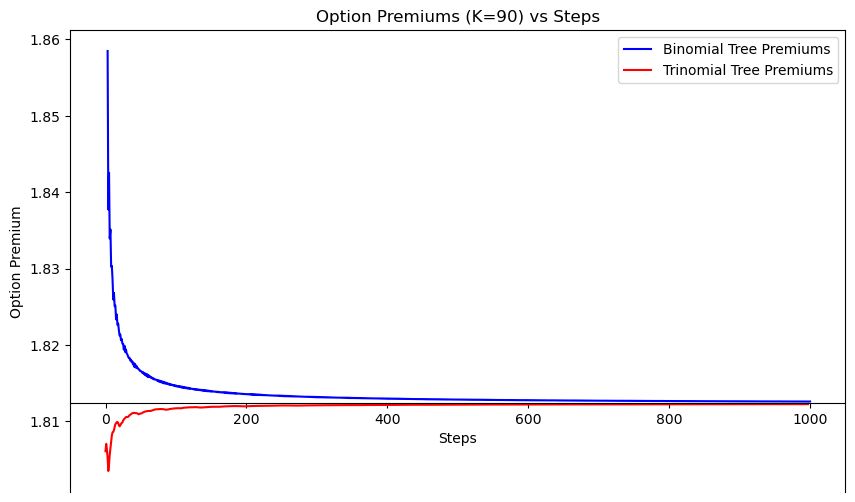

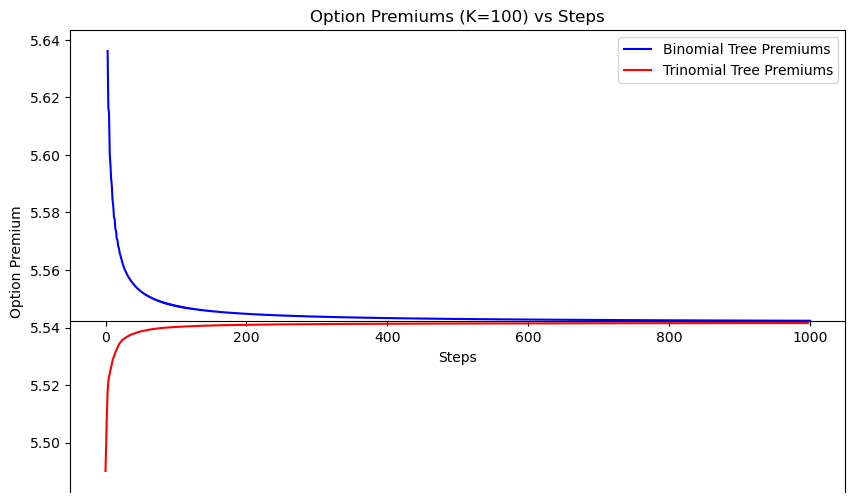

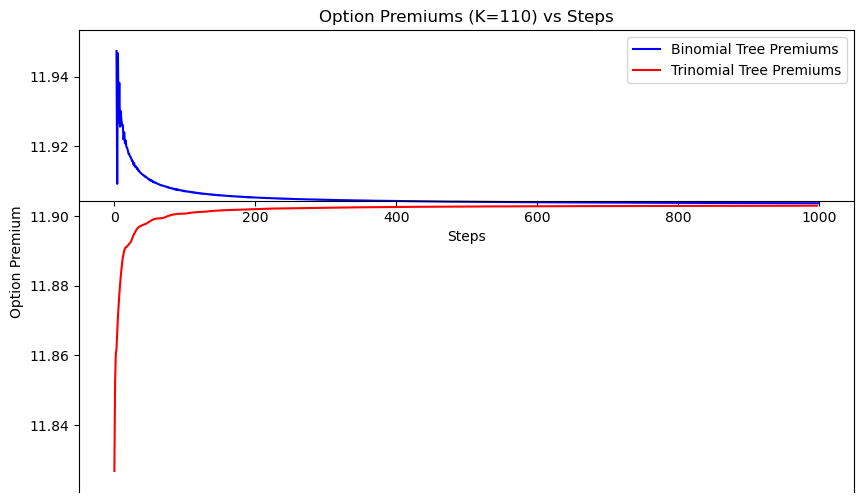

In [201]:
# Plotting
# steps for the x-axis
steps = np.arange(3, 1001)

# K=90
plt.figure(figsize=(10, 6))
plt.plot(steps, american_put_binomial_90, label='Binomial Tree Premiums', color='blue')
plt.plot(american_put_trinomial_90, label='Trinomial Tree Premiums', color='red')

# Adjusting spines to make x-axis
ax = plt.gca()
ax.spines['bottom'].set_position(('data', q3_price_90))

plt.xlabel('Steps')
plt.ylabel('Option Premium')
plt.title('Option Premiums (K=90) vs Steps')
plt.legend()
plt.show()

# K=100
plt.figure(figsize=(10, 6))
plt.plot(steps, american_put_binomial_100, label='Binomial Tree Premiums', color='blue')
plt.plot(american_put_trinomial_100, label='Trinomial Tree Premiums', color='red')

# Adjusting spines to make x-axis 
ax = plt.gca()
ax.spines['bottom'].set_position(('data', q3_price_100))

plt.xlabel('Steps')
plt.ylabel('Option Premium')
plt.title('Option Premiums (K=100) vs Steps')
plt.legend()
plt.show()

# K=110
plt.figure(figsize=(10, 6))
plt.plot(steps, american_put_binomial_110, label='Binomial Tree Premiums', color='blue')
plt.plot(american_put_trinomial_110, label='Trinomial Tree Premiums', color='red')

# Adjusting spines to make x-axis 
ax = plt.gca()
ax.spines['bottom'].set_position(('data', q3_price_110))

plt.xlabel('Steps')
plt.ylabel('Option Premium')
plt.title('Option Premiums (K=110) vs Steps')
plt.legend()
plt.show()

# Question 5

In [117]:
# Option prices from trinomial tree with N=200 and no dividends
trinomial_200_nodiv_90 = trinomial_american_tree(K[0], S0, T, 200, r, 0, sigma)
trinomial_200_nodiv_100 = trinomial_american_tree(K[1], S0, T, 200, r, 0, sigma)
trinomial_200_nodiv_110 = trinomial_american_tree(K[2], S0, T, 200, r, 0, sigma)

# Adjustments from the CJM model
adj_90 = trinomial_200_nodiv_90 - q3_price_90
adj_100 = trinomial_200_nodiv_100 - q3_price_100
adj_110 = trinomial_200_nodiv_110 - q3_price_110 

print(f"Adjustment K=90: {adj_90}")
print(f"Adjustment K=90: {adj_100}")
print(f"Adjustment K=90: {adj_110}")

# Adjusted trinomial price with N=200
trinomial_200_90 = trinomial_american_tree(K[0], S0, T, 200, r, y, sigma) + adj_90
trinomial_200_100 = trinomial_american_tree(K[1], S0, T, 200, r, y, sigma) + adj_100
trinomial_200_110 = trinomial_american_tree(K[2], S0, T, 200, r, y, sigma) + adj_110

Adjustment K=90: [-0.00047787]
Adjustment K=90: [-0.00123844]
Adjustment K=90: [-0.00242092]


In [116]:
# Binomial price with N=2000
binomial_2000_90 = CRR_american_tree_BSM_adjustment(K[0], T, S0, r, y, sigma, 2000)
binomial_2000_100 = CRR_american_tree_BSM_adjustment(K[1], T, S0, r, y, sigma, 2000)
binomial_2000_110 = CRR_american_tree_BSM_adjustment(K[2], T, S0, r, y, sigma, 2000)

In [97]:
print(f"Adjusted Trinomial Tree American Put Price (Steps=200, K=90): {trinomial_200_90[0]}")
print(f"Binomial Tree American Put Price (Steps=2000, K=90): {binomial_2000_90}")
print(f"\nAdjusted Trinomial Tree American Put Price (Steps=200, K=100): {trinomial_200_100[0]}")
print(f"Binomial Tree American Put Price (Steps=2000, K=100): {binomial_2000_100}")
print(f"\nAdjusted Trinomial Tree American Put Price (Steps=200, K=110): {trinomial_200_110[0]}")
print(f"Binomial Tree American Put Price (Steps=2000, K=110): {binomial_2000_110}")

Adjusted Trinomial Tree American Put Price (Steps=200, K=90): 1.9045196375242932
Binomial Tree American Put Price (Steps=2000, K=90): 1.9053188016003297

Adjusted Trinomial Tree American Put Price (Steps=200, K=100): 5.72751042173364
Binomial Tree American Put Price (Steps=2000, K=100): 5.729538790876991

Adjusted Trinomial Tree American Put Price (Steps=200, K=110): 12.13973801511081
Binomial Tree American Put Price (Steps=2000, K=110): 12.143120141998418
